# Random walk

In [1]:
import sys
import numpy as np
import corner
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import logging

from goldmine.simulators.random_walk_checkpointed import CheckpointedRandomWalk
from goldmine.inference.scandal_checkpointed import CheckpointedSCANDALInference

In [2]:
logging.basicConfig(format='%(asctime)s  %(message)s', datefmt='%H:%M')
logging.getLogger().setLevel(logging.INFO)

In [3]:
def ccolor(val, vmin, vmax, cmap='viridis'):
    cmap = matplotlib.cm.get_cmap(cmap)
    return cmap((val - vmin) / (vmax - vmin)).reshape(-1,)

## Setup

In [26]:
checkpoints = np.linspace(0.,1.,11)
xmin, xmax = -40, 40

## Test data

In [34]:
n_sim = 1000
n_plot = 100

theta_test = 110.

In [18]:
sim = CheckpointedRandomWalk()
x_test, t_xz_test, z_checkpoints_test, t_xz_checkpoints_test, z_test = sim.rvs_score([theta_test], [theta_test], n_sim, return_histories=True)


## Load and evaluate model

In [19]:
inf = CheckpointedSCANDALInference(
    filename = "../../data/models/randomwalk/scandal_checkpoint/model"
)

14:57  Loaded checkpointed SCANDAL from file:
14:57    Filename:        ../../data/models/randomwalk/scandal_checkpoint/model
14:57    Checkpoint score estimator:
14:57      Hidden layers: (20, 20)
14:57      Activation:    <built-in method relu of type object at 0xb1ae4a870>
14:57      Parameters:    1
14:57      Latents:       1
14:57    Global flow:
14:57      Parameters:    1
14:57      Observables:   1
14:57      Components:    1
14:57      MADEs:         5
14:57      Hidden layers: (100,)
14:57      Activation:    tanh
14:57      Batch norm:    False


In [20]:
t_x_test = inf.predict_score(
    theta=theta_test * np.ones_like(t_xz_test),
    x=x_test
)
t_xzcp_test = inf.predict_checkpoint_scores(
    theta=theta_test * np.ones_like(t_xz_test),
    z_checkpoints=z_checkpoints_test
)

## Plot scores

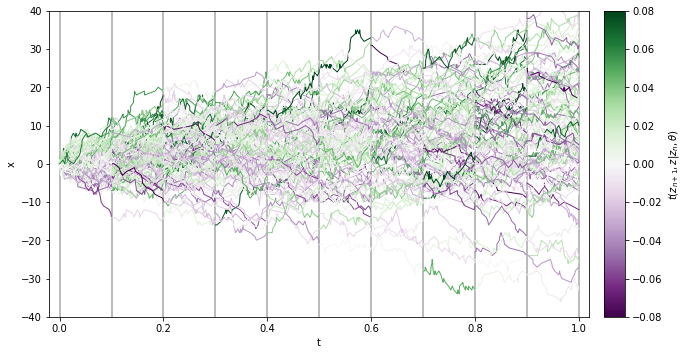

In [36]:
vmax = 0.08

fig = plt.figure(figsize=(10,5))
ax0 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

# Checkpoints
for t_checkpoint in checkpoints:
    plt.plot(
        [t_checkpoint, t_checkpoint], [xmin, xmax],
        ls='-',
        c='0.65',
        lw=1.5
    )
    
# Joint scores for theta0 trajectories
for z, z_cp, t_xz in zip(z_test[:n_plot], z_checkpoints_test[:n_plot], t_xz_checkpoints_test[:n_plot]):
    for i in range(len(checkpoints) - 1):
        t = np.array(z)[:,0]
        x = np.array(z)[:,1]
        
        tmin, tmax = checkpoints[i], checkpoints[i+1]
        t_ = t[(t >= tmin) & (t < tmax)]
        x_ = x[(t >= tmin) & (t < tmax)]
        
        t_ = np.hstack([[checkpoints[i]], t_, [checkpoints[i+1]]])
        x_ = np.hstack([z_cp[i], x_, z_cp[i+1]])
        
        plt.plot(
            t_, x_,
            c=ccolor(t_xz[i+1], -vmax, vmax, 'PRGn'),
            ls='-', lw=1., alpha=1.
        )
    
plt.xlim(-0.02,1.02)
plt.ylim(xmin, xmax)

plt.xlabel('t')
plt.ylabel('x')

# Color bar
ax1 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
cb = matplotlib.colorbar.ColorbarBase(
    ax1, cmap=matplotlib.cm.get_cmap("PRGn"),
    norm=matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax),
    orientation='vertical'
)
cb.set_label(r'$t(z_{n+1}, z | z_n, \theta)$')
    
plt.savefig('random_walk_joint_score.pdf')
plt.show()

## Plot estimated checkpoint scores

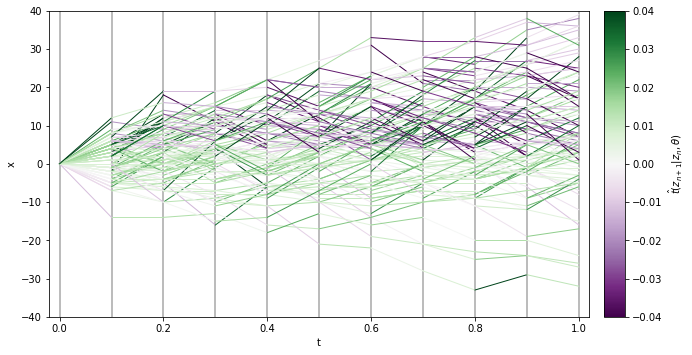

In [37]:
vmax = 0.04

fig = plt.figure(figsize=(10,5))
ax0 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

# Checkpoints
for t_checkpoint in checkpoints:
    plt.plot(
        [t_checkpoint, t_checkpoint], [xmin, xmax],
        ls='-',
        c='0.65',
        lw=1.5
    )
    
# Joint scores for theta0 trajectories
for z, t_xz in zip(z_checkpoints_test[:n_plot], t_xzcp_test[:n_plot]):
    for i in range(len(checkpoints) - 1):
        plt.plot(
            [checkpoints[i], checkpoints[i+1]], [z[i,0], z[i+1,0]],
            c=ccolor(t_xz[i], -vmax, vmax, 'PRGn'),
            ls='-', lw=1., alpha=1.
        )
    
plt.xlim(-0.02,1.02)
plt.ylim(xmin, xmax)

plt.xlabel('t')
plt.ylabel('x')

# Color bar
ax1 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
cb = matplotlib.colorbar.ColorbarBase(
    ax1, cmap=matplotlib.cm.get_cmap("PRGn"),
    norm=matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax),
    orientation='vertical'
)
cb.set_label(r'$\hat{t}(z_{n+1}| z_n, \theta)$')
    
plt.savefig('random_walk_checkpoint_score.pdf')
plt.show()

## Plot estimated overall score

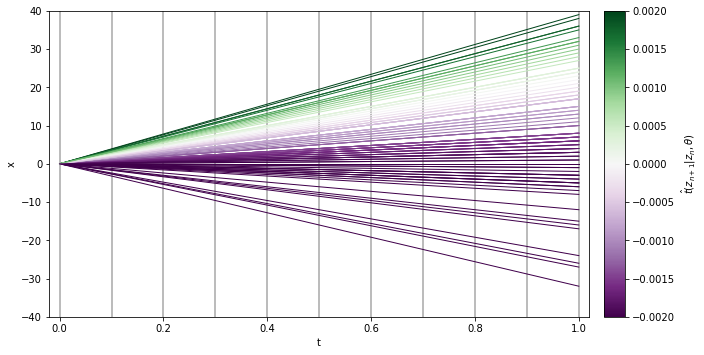

In [38]:
vmax = 0.002

fig = plt.figure(figsize=(10,5))
ax0 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

# Checkpoints
for t_checkpoint in checkpoints:
    plt.plot(
        [t_checkpoint, t_checkpoint], [xmin, xmax],
        ls='-',
        c='0.65',
        lw=1.5
    )
    
# Joint scores for theta0 trajectories
for x, t_x in zip(x_test[:n_plot], t_x_test[:n_plot]):
    plt.plot(
        [0., 1.], [0.,x[0]],
        c=ccolor(t_x, -vmax, vmax, 'PRGn'),
        ls='-', lw=1., alpha=1.
    )
    
plt.xlim(-0.02,1.02)
plt.ylim(xmin, xmax)

plt.xlabel('t')
plt.ylabel('x')

# Color bar
ax1 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
cb = matplotlib.colorbar.ColorbarBase(
    ax1, cmap=matplotlib.cm.get_cmap("PRGn"),
    norm=matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax),
    orientation='vertical'
)
cb.set_label(r'$\hat{t}(z_{n+1}| z_n, \theta)$')
    
plt.savefig('random_walk_score.pdf')
plt.show()

## Checkpoint-to-checkpoint score

In [86]:
in_micro = z_checkpoints_test[:, :-1, 0].flatten()
out_micro = z_checkpoints_test[:, 1:, 0].flatten()
diff_micro = out_micro - in_micro

t_xz_micro = t_xz_checkpoints_test[:, 1:, 0].flatten()
t_x_micro = t_xzcp_test[:, :, 0].flatten()

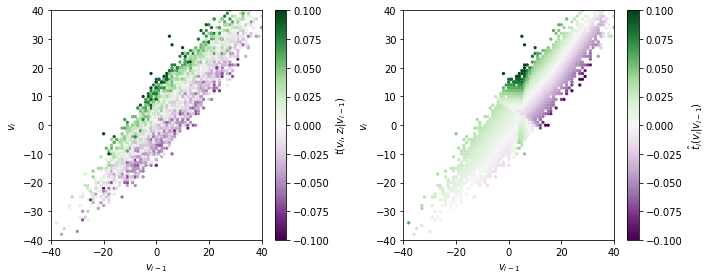

In [94]:
vmax = 0.1
fig = plt.figure(figsize=(10.,4.))


ax = plt.subplot(1,2,1)

sc = plt.scatter(in_micro, out_micro, c=t_xz_micro, cmap='PRGn', vmin=-vmax, vmax=vmax, s=5.)
cb = plt.colorbar(sc)

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel(r'$v_{i-1}$')
plt.ylabel(r'$v_{i}$')
cb.set_label(r'$t(v_i, z_i | v_{i-1})$')


ax = plt.subplot(1,2,2)

sc = plt.scatter(in_micro, out_micro, c=t_x_micro, cmap='PRGn', vmin=-vmax, vmax=vmax, s=5.)
cb = plt.colorbar(sc)

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel(r'$v_{i-1}$')
plt.ylabel(r'$v_{i}$')
cb.set_label(r'$\hat{t}_i(v_i | v_{i-1})$')


plt.tight_layout()
plt.savefig('random_walk_micro_score.pdf')


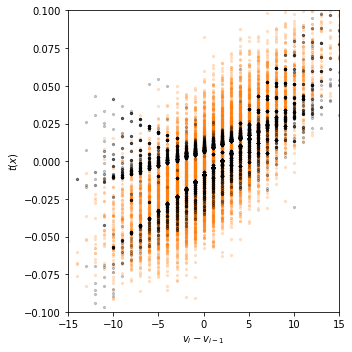

In [93]:
vmax=0.1

fig = plt.figure(figsize=(5,5))

plt.scatter(diff_micro, t_xz_micro, c='C1', s=5., alpha=0.2)
plt.scatter(diff_micro, t_x_micro, c='black', s=5., alpha=0.2)

plt.xlabel(r'$v_i - v_{i-1}$')
plt.ylabel(r'$t(x)$')

plt.xlim(-15., 15.)
plt.ylim(-vmax, vmax)

plt.tight_layout()
plt.savefig('random_walk_micro_score_vs_diff.pdf')


In [59]:
out_micro.shape

(10000,)

## Global model

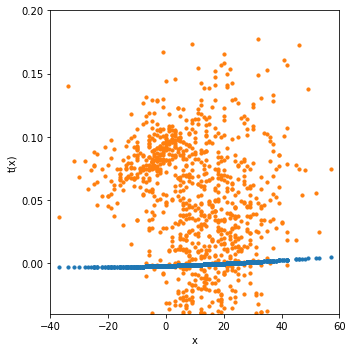

In [48]:
fig = plt.figure(figsize=(5,5))

plt.scatter(x_test.flatten(), np.sum(t_xzcp_test, axis=1).flatten(), c='C1', s=10.)
plt.scatter(x_test.flatten(), t_x_test.flatten(), c='C0', s=10.)

plt.xlabel('x')
plt.ylabel('t(x)')

plt.xlim(-40., 60.)
plt.ylim(-0.04, 0.2)
plt.tight_layout()
plt.show()